### <span style="color:orange"> Install CUDA (GPU drivers from NVIDIA) </span>

- import Pkg; Pkg.add("CUDA");

In [41]:
#import Pkg; Pkg.add("CUDA");
using CUDA

#### By default, Flux will run the checks on your system to see if it can support GPU functionality. You can check if Flux identified a valid GPU setup by typing the following:

In [42]:
CUDA.functional() #check if Flux can find your GPU

false

#### you need to **->move<-** <u>model weights</u> and <u>data</u> to the GPU and Flux will handle it.

- you need to tell Flux that the weights and the data need to go to the GPU to be used in the computation by the GPU

In [43]:
using Flux, Statistics, ProgressMeter
using Plots 
using StatsBase, Random

## <span style="color:orange"> Keyword `gpu` is a function to put models and data onto the GPU </span>

- Float32 is the typical single precision on GPUs

In [36]:
using RDatasets
iris = dataset("datasets", "iris");

In [37]:
typeof(iris)
display( iris[1:3,:])

Row,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
,Float64,Float64,Float64,Float64,Cat…
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa


In [38]:
features = iris[:,1:4]
features = Matrix{Float32}(features) 
println( typeof( features ) )
targets = iris[:,5];

Matrix{Float32}


In [39]:
length( unique( iris[:,end] ) )

3

In [40]:
length( iris[:,end] )

150

In [41]:
odd_inds = findall( mod.(1:150,2) .== 1)
even_inds = findall( mod.(1:150,2) .== 0);

In [42]:
x_train , x_test = features[odd_inds,:] , features[even_inds,:];
y_train , y_test = targets[odd_inds] , targets[even_inds];
println( "x_train size before ", size(x_train) )
x_train = x_train'
x_test = x_test'
println( "x_train size after ", size(x_train) )

x_train size before (75, 4)
x_train size after (4, 75)


In [43]:
#we need to make 1-hot encoding of the categorical values
species = unique( iris[:,end] )
y_train = Flux.onehotbatch( y_train , species )
display( size(y_train) )
y_test = Flux.onehotbatch( y_test , species )

(3, 75)

3×75 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     1  1  1  1  1  1  1  1  1  1  1  1

In [46]:
#put onto the GPU
species |> gpu
x_train |> gpu
x_test |> gpu
y_train |> gpu
y_test |> gpu

3×75 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     1  1  1  1  1  1  1  1  1  1  1  1

    
- if a GPU is -not- present it will do nothing, it runs on the GPU if the library CUDA.jl loads successfully 
- this function moves data to the GPU from the CPU space  
                    
![by Damien Benveniste ](./cpugputpu.jpg)

(TPUs are not recommended to sequential models like LSTMs and they require longer runs to derive benefit over the GPU)

In [26]:
#make a model for predicting the species (categorical output)
model_iris = Chain( Dense( 4=>8, relu ) , Dense( 8=>3, sigmoid ) , softmax ) |> gpu

Chain(
  Dense(4 => 8, relu),                  # 40 parameters
  Dense(8 => 3, σ),                     # 27 parameters
  NNlib.softmax,
)                   # Total: 4 arrays, 67 parameters, 524 bytes.

### <span style="color:orange"> The data and model is brought back from the GPU to the CPU with the function `cpu` </span>

- if the data has been moved to the GPU it is necessary to run `cpu` in order to do things like plot the data

In [54]:
#put back onto the CPU
species |> gpu
x_train |> cpu
x_test |> cpu
y_train |> cpu
y_test |> cpu

3×75 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     1  1  1  1  1  1  1  1  1  1  1  1

In [49]:
println( "model output = " , model_iris( x_train[:,1] ) )
println( "category output predicted ('one-cold') = " , Flux.onecold( model_iris(x_train[:,1]), species ) )
println( "true output label = " , Flux.onecold( y_train[:,1], species ) )
#try out the cross entropy
println( "cross entropy of prediction and target = " , Flux.crossentropy( model_iris( x_train[:,1] ) , y_train[:,1] ) )
println( "cross entropy of predictions and multiple targets = " , Flux.crossentropy( model_iris( x_train[:,1:20] ) , y_train[:,1:20] ) )
hits = Flux.onecold( model_iris( x_train ) , species ) .== Flux.onecold( y_train , species )
accuracy = 100 * sum( hits ) / length( hits )
println( "init accuracy = ", accuracy , "%")

model output = Float32[0.562212, 0.22195598, 0.21583201]
category output predicted ('one-cold') = setosa
true output label = setosa
cross entropy of prediction and target = 0.57587606
cross entropy of predictions and multiple targets = 0.5770652
init accuracy = 33.333333333333336%


In [55]:
#put back onto the GPU
species |> gpu
x_train |> gpu
x_test |> gpu
y_train |> gpu
y_test |> gpu

3×75 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     1  1  1  1  1  1  1  1  1  1  1  1

In [51]:
#pack the data and put onto the gpu
data = Flux.DataLoader( (x_train, y_train) , batchsize=10 , shuffle=true ) |> gpu

MLUtils.DataLoader{Tuple{LinearAlgebra.Adjoint{Float32, Matrix{Float32}}, OneHotArrays.OneHotMatrix{UInt32, 3, Vector{UInt32}}}, Random._GLOBAL_RNG, Val{nothing}}((Float32[5.1 4.7 … 6.3 6.2; 3.5 3.2 … 2.5 3.4; 1.4 1.3 … 5.0 5.4; 0.2 0.2 … 1.9 2.3], Bool[1 1 … 0 0; 0 0 … 0 0; 0 0 … 1 1]), 10, false, true, true, false, Val{nothing}(), Random._GLOBAL_RNG())

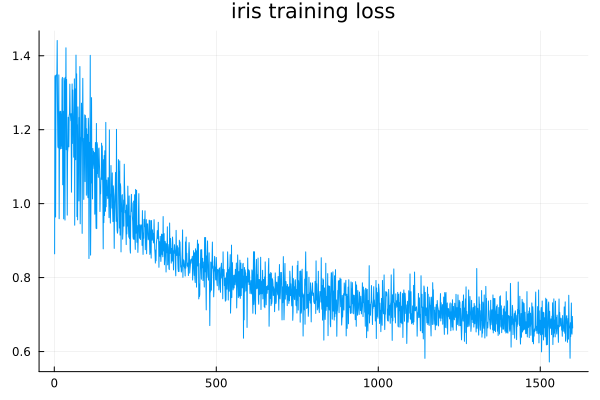

In [52]:
#train the parameters to predict iris
opt = Flux.setup( Flux.Adam(0.001) , model_iris ) |> gpu
losses = []
for epoch in 1:200
    for data_tmp in data    
        #get the gradients
        loss_tmp, grads = Flux.withgradient(model_iris) do model
            y_hat = model(data_tmp[1])
            Flux.crossentropy(y_hat,data_tmp[2])
        end
        Flux.update!(opt, model_iris, grads[1])
        push!(losses,loss_tmp) #don't put this in the above block where the gradient is computed
    end
end
p1 = plot( losses , title="iris training loss" , legend=false )
#savefig("./p1.png") #save the plot in the current directory
display(p1)

In [57]:
model_iris |> cpu
species |> cpu
x_train |> cpu
x_test |> cpu
y_train |> cpu
y_test |> cpu

hits = Flux.onecold( model_iris( x_train ) , species ) .== Flux.onecold( y_train , species )
accuracy = 100 * sum( hits ) / length( hits )
println( "Iris train accuracy = ", accuracy , "%" )

hits = Flux.onecold( model_iris( x_test ) , species ) .== Flux.onecold( y_test , species )
accuracy = 100 * sum( hits ) / length( hits )
println( "Iris test accuracy = ", accuracy , "%" )

Iris train accuracy = 96.0%
Iris test accuracy = 96.0%


In [28]:
#import Pkg; Pkg.add("MLDatasets")
#import Pkg; Pkg.add("ImageInTerminal")
#import Pkg; Pkg.add("ImageShow")
#import Pkg; Pkg.add("Images")
#import Pkg; Pkg.add("ImageIO")
#import Pkg; Pkg.add("ImageMagick")
using ImageShow, Images, ImageInTerminal
using MLDatasets

In [8]:
train_x_raw, train_y_raw = MNIST(split = :train)[:]
test_x_raw,  test_y_raw  = MNIST(split = :test)[:];
println( "train_x_raw size = $(size(train_x_raw)), train_y_raw size = $(size(train_y_raw))")
display( train_y_raw[1:5] )

train_x_raw size = (28, 28, 60000), train_y_raw size = (60000,)


5-element Vector{Int64}:
 5
 0
 4
 1
 9

[5, 0, 4, 1, 9]


,,,,

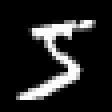
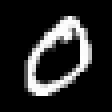
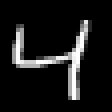
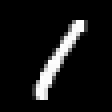
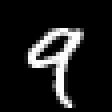

In [36]:
println( [ train_y_raw[ ii ] for ii in 1:5 ] )
[ convert2image(MNIST, train_x_raw[ : , : , ii ] ) for ii in 1:5 ]

[5, 0, 4, 1, 9]


,,,,

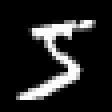
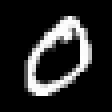
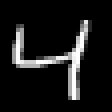
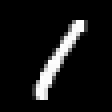
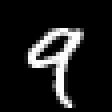

In [35]:
#color view needs the transpose since the x and y are flipped
println( [ train_y_raw[ ii ] for ii in 1:5 ] )
[ colorview( Gray , train_x_raw[ : , : , ii ]' ) for ii in 1:5 ]

In [45]:
#make the data from matrix to vector
train_x = Flux.flatten(train_x_raw)
test_x = Flux.flatten(test_x_raw)
println( "size of train_x = $(size(train_x))")
println( "28 x 28 = $(28*28)")

size of train_x = (784, 60000)
28 x 28 = 784


In [48]:
train_y = Flux.onehotbatch( train_y_raw , 0:9 )
test_y  = Flux.onehotbatch( test_y_raw , 0:9 )
println( "size of train_y = $(size(train_y))" )
println( "unique train_y_raw = $(unique(train_y_raw))" )
display( train_y[ : , 1:3 ] )

size of train_y = (10, 60000)
unique train_y_raw = [5, 0, 4, 1, 9, 2, 3, 6, 7, 8]


10×3 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  1  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  1
 1  ⋅  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅

In [51]:
model_digits = Chain( Dense( 28*28=>60 , sigmoid) , Dense( 60=>32 , relu ) , Dense( 32=>10 , relu ) , softmax ) 

Chain(
  Dense(784 => 60, σ),                  # 47_100 parameters
  Dense(60 => 32, relu),                # 1_952 parameters
  Dense(32 => 10, relu),                # 330 parameters
  NNlib.softmax,
)                   # Total: 6 arrays, 49_382 parameters, 193.273 KiB.

In [56]:
#test the model at init ( untrained ) on 1 image
model_digits( train_x[:,1] )

10-element Vector{Float32}:
 0.06902272
 0.08928758
 0.0757365
 0.06902272
 0.07147487
 0.10623115
 0.06902272
 0.31215638
 0.06902272
 0.06902272

In [59]:
#test the model at init ( untrained ) on 3 images
model_digits( train_x[:,1:3] )

10×3 Matrix{Float32}:
 0.0690227  0.0728325  0.080467
 0.0892875  0.0836149  0.0961999
 0.0757365  0.0836079  0.0767386
 0.0690227  0.0728325  0.0756563
 0.0714748  0.0728325  0.0756563
 0.106231   0.0961023  0.0993672
 0.0690227  0.0728325  0.0756563
 0.312156   0.299679   0.268946
 0.0690227  0.0728325  0.0756563
 0.0690227  0.0728325  0.0756563

In [54]:
data_digits = Flux.DataLoader( (train_x, train_y) , batchsize=5 , shuffle=true )


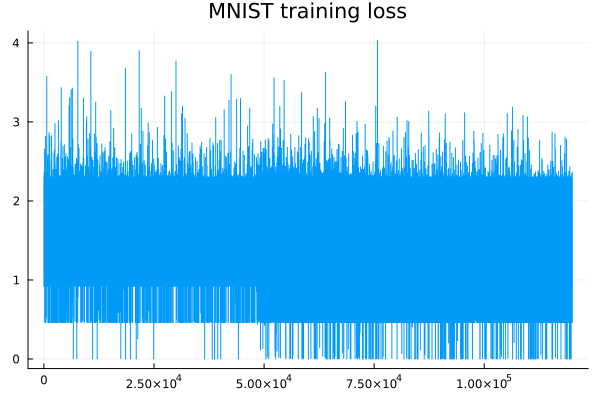

In [70]:
opt = Flux.setup( Flux.Adam(0.001) , model_digits );

losses = []
for epoch in 1:10
    for ( x , y ) in data_digits        
        
        loss_tmp, grads = Flux.withgradient( model_digits ) do model                        
                
            y_hat = model( x )
            loss = Flux.crossentropy( y_hat , y )
            return loss
            
        end     
        Flux.update!( opt , model_digits , grads[1] )
        push!(losses,loss_tmp) #don't put this in the above block where the gradient is computed
    end
    
end
p1 = plot( losses , title="MNIST training loss" , legend=false )
savefig(p1,"p1.png")
display(p1)